**Please note this jupyter notebook is in Python, if you are looking for a Julia version of Gillespie Algorithm, please click the following link of habitat occupancy.**

https://github.com/je-suis-tm/graph-theory/blob/master/habitat%20occupancy.ipynb

Gillespie Algorithm is an algorithm that simulates statistically correct reaction of each individual at each discrete step with respective to the underlying equations.

If you want to know more about Gillespie Algorithm, check CalTech's Jupyter Notebook. 

Apart from the algorithm per se, it also provides tutorials on how to use numba and multiprocessing to speed things up.

http://be150.caltech.edu/2016/handouts/gillespie_simulation.html

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import imageio
import copy
import pandas as pd
import numba
import os
os.chdir('k:/')

In [2]:
#simulate status change of each agent
#in order to boost the performance of the algorithm
#we can only use one package, numpy
#the code itself may look obselete
#becuz only a few numpy functions are supported in numba
#details are in the following link
# http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

@numba.jit(nopython=True)
def gillespie(adjmatrix,param):
    
    #unpack
    tmax,t,infection_rate,recovery_rate,S0,I0,R0=param
    
    #initial
    n_S=S0
    n_I=I0
    n_R=R0
    list_S,list_I,list_R=[S0],[I0],[R0]
    
    #create status of each agent
    #0 denotes susceptible
    #1 denotes infected
    #-1 denotes recovered
    status=np.array([0]*S0+[1]*I0+[-1]*R0)
    np.random.shuffle(status)
    list_t=[0]
    
    #de facto deep copy
    list_status=[i for i in status]

    #unless every patient is recovered
    #or t has reach the maximum elapsed time
    #nothing is gonna stop us now
    while t<tmax:
        if n_I==0:
            break
        
        #compute propensity
        propensity1=infection_rate*n_S*n_I 
        propensity2=recovery_rate*n_I
        propensity_all=propensity1+propensity2
        
        #tau leaping
        tau=-np.log(np.random.rand())/propensity_all
        t=t+tau

        currently_infected=np.array([i for i in range(adjmatrix.shape[0]) if status[i]==1])
        
        if np.random.rand()<propensity1/propensity_all:

            #if people around susceptible cannot spread disease
            #we have to terminate the infection
            #otherwise we stuck in infinitive loops
            currently_susceptible=[i for i in range(adjmatrix.shape[0]) if status[i]==0]
            
            #this part looks confusing
            #it is equivalent to [status[j] for i in currently_susceptible for j in graph.neighbors(i)]
            neighbor_status=[status[j] for i in currently_susceptible for j in [ii for ii in range(adjmatrix.shape[0]) if adjmatrix[ii][i]==1]]
            if (neighbor_status).count(1)==0:
                continue

            #randomly select an infected patient
            #randomly select one of her/his susceptible connections
            #infect that poor soul
            stop=False
            while not stop:
                selected=np.random.choice(currently_infected,1)[0]
                
                #this part looks confusing
                #it is equivalent to [i for i in graph.neighbors(selected) if status[i]==0]     
                connections=np.array([i for i in [ii for ii in range(adjmatrix.shape[0]) if adjmatrix[ii][selected]==1] if status[i]==0])
                if connections.shape!=(0,):
                    new_infected=np.random.choice(connections,1)[0]
                    stop=True

            #update data
            status[new_infected]=1        
            n_S=n_S-1
            n_I=n_I+1
            
        else:

            #cure a random infected patient
            selected=np.random.choice(currently_infected,1)[0]

            #update data
            status[selected]=-1        
            n_I=n_I-1
            n_R=n_R+1

        #update data
        list_S.append(n_S)
        list_I.append(n_I)
        list_R.append(n_R)
        list_t.append(t)
        
        #numba doesnt support nested list
        #thus, we need to improvise
        list_status+=[i for i in status]
        
    return list_t,list_status,list_S,list_I,list_R

In [3]:
#create dataframe for visualization
def create_data(graph,list_t,matrix_status,colorlist):
    
    #unpack
    recovered_color,susceptible_color,infected_color=colorlist
    
    #create dataframe
    data=pd.DataFrame(index=graph.nodes,columns=list_t)
    for i in range(len(data.columns)):
        data[data.columns[i]]=matrix_status[i]
    
    #cleanup
    df=data.T
    df.reset_index(inplace=True)
    
    #discrete time rounding
    df['time']=df['index'].apply(int).diff(-1)
    df.at[0,'time']=-1
    df.at[len(df)-1,'time']=-1
    df=df.loc[df[df['time']!=0].index]
    df['real time']=df['index'].apply(lambda x:int(x)+1)
    df.at[0,'real time']=0
    
    #cleanup
    del df['index']
    del df['time']    
    df.set_index('real time',inplace=True)
    df=df.T
        
    return df

In [4]:
#visualize agent-based model
def plot_graph(df,graph,colorlist,save_gif=False):
    
    #unpack
    recovered_color,susceptible_color,infected_color=colorlist
    
    #fix positions
    pos=nx.spring_layout(graph)
    
    #everytime there is a status change
    #we visualize it
    for i in df.columns:
        plt.title(f't={i}')
        
        #replace value with color
        nx.draw(graph,pos,node_color=df[i].replace({-1:recovered_color,
                                                   0:susceptible_color,
                                                   1:infected_color}))
        
        #create legends
        S=mlines.Line2D([],[],color=susceptible_color,
                                  marker='o',markersize=10,
                                  linewidth=0,label='Susceptible')
        I=mlines.Line2D([],[],color=infected_color,
                                  marker='o',markersize=10,
                                  linewidth=0,label='Infected')
        R=mlines.Line2D([],[],color=recovered_color,
                                  marker='o',markersize=10,
                                  linewidth=0,label='Recovered')
        plt.legend(handles=[S,I,R],loc=0)
        
        if save_gif:
            plt.savefig(f't{i}.png')        
        plt.show()
    
    #create gif
    if save_gif:
        filenames=["t%d.png" % (ii) for ii in df.columns]
        images=list(map(lambda filename:imageio.imread(filename),
                        filenames))
        imageio.mimsave('movie.gif',images,duration=0.5)

&nbsp;
### Visualization
&nbsp;

In [5]:
#maximum elapsed time
tmax=50

#beginning time
t=0

#initial
infection_rate=0.01
recovery_rate=0.06
S0=49
I0=1
R0=0
N=S0+I0+R0

#data preparation
param=(tmax,t,infection_rate,recovery_rate,S0,I0,R0)
colorlist=['#99B898','#FECEAB','#FF847C']
graph=nx.erdos_renyi_graph(n=(S0+I0+R0),p=0.2)
adjmatrix=nx.to_numpy_array(graph)

In [6]:
list_t,list_status,_,_,_=gillespie(adjmatrix,param)

In [7]:
matrix_status=[list_status[i:i+N] for i in range(0,len(list_status),N)]

In [8]:
df=create_data(graph,list_t,matrix_status,colorlist)

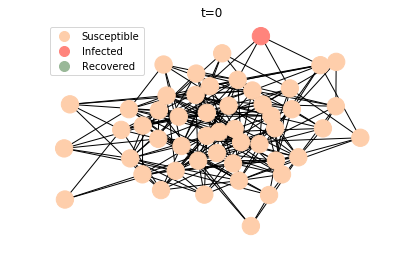

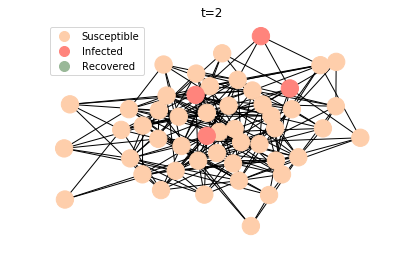

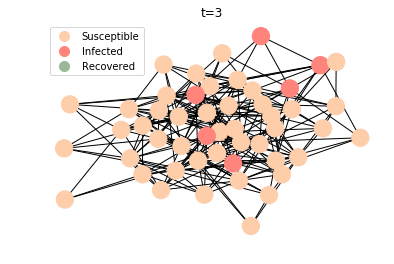

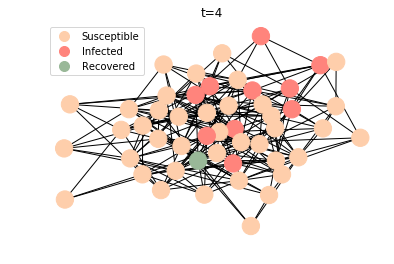

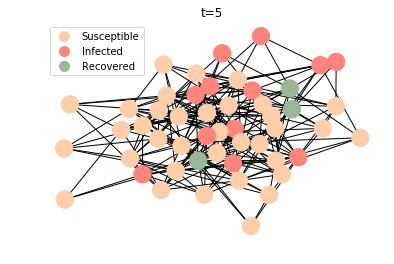

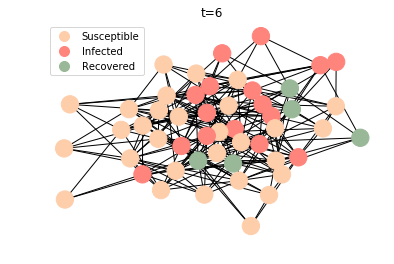

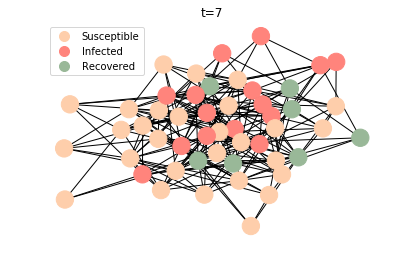

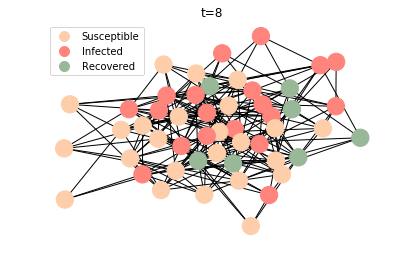

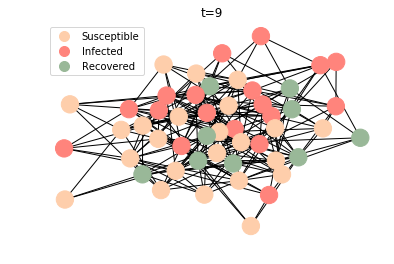

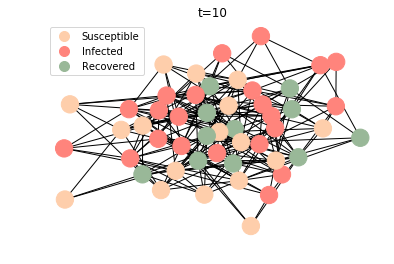

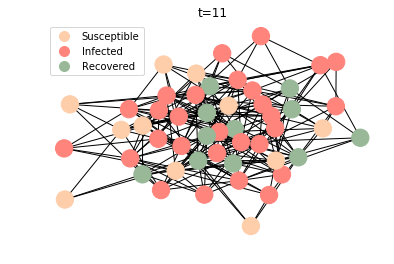

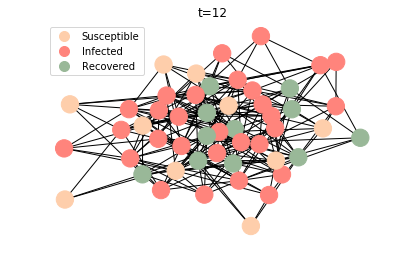

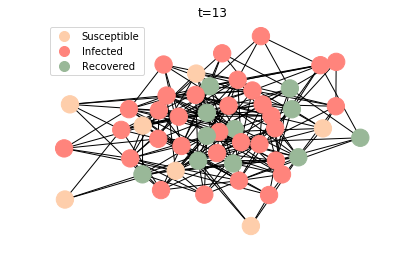

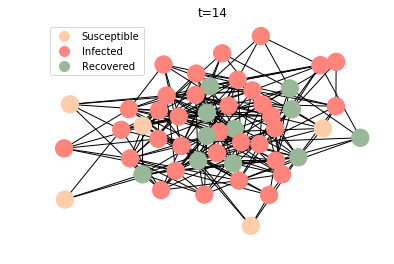

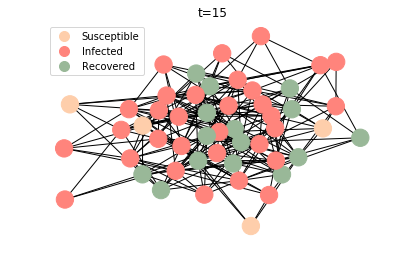

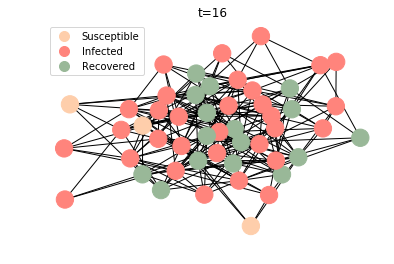

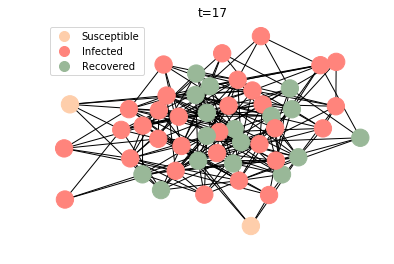

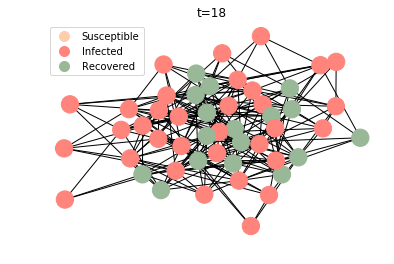

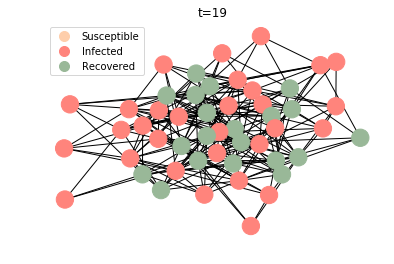

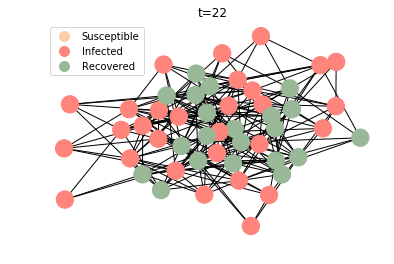

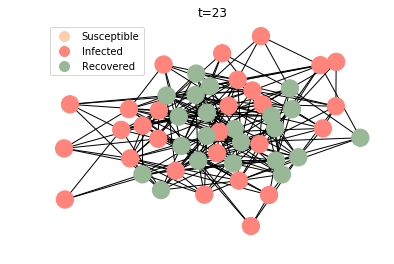

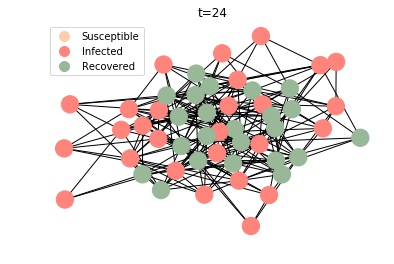

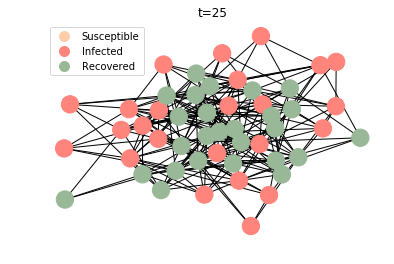

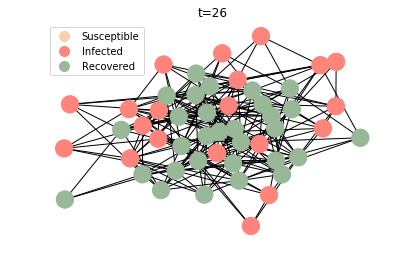

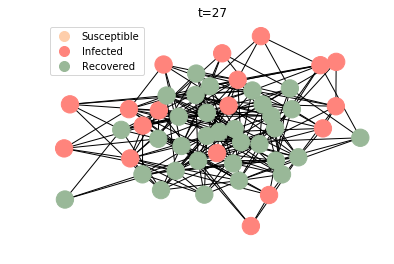

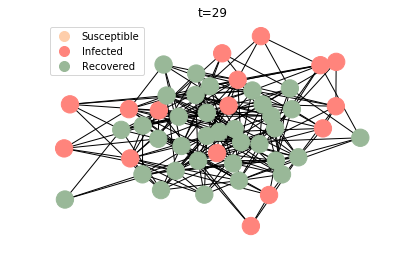

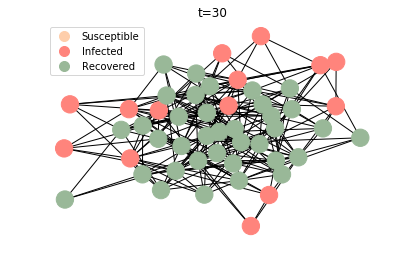

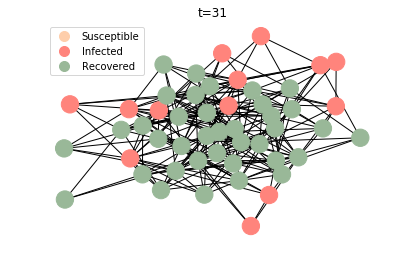

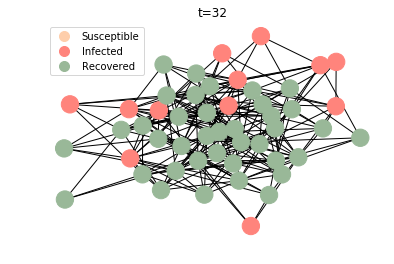

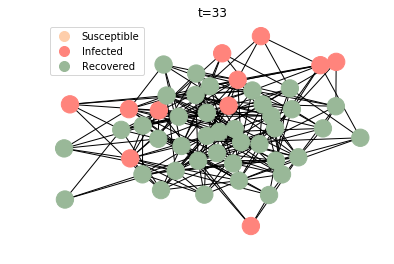

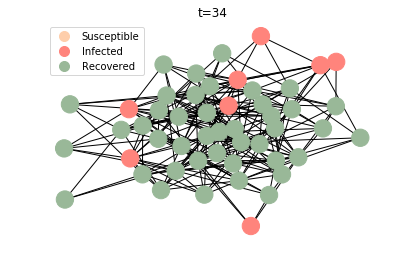

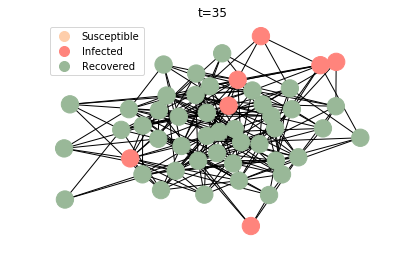

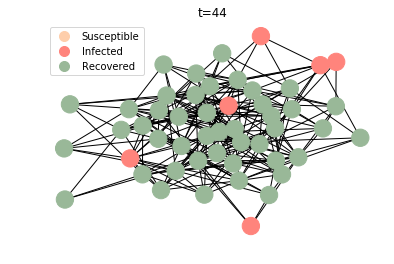

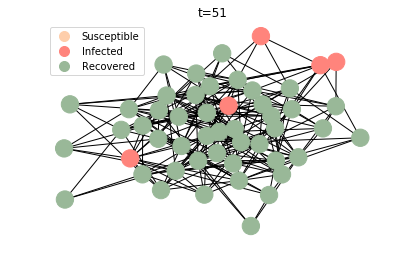

In [9]:
plot_graph(df,graph,colorlist)

&nbsp;
### Degree Distribution
&nbsp;

In [10]:
#initial
N=1000

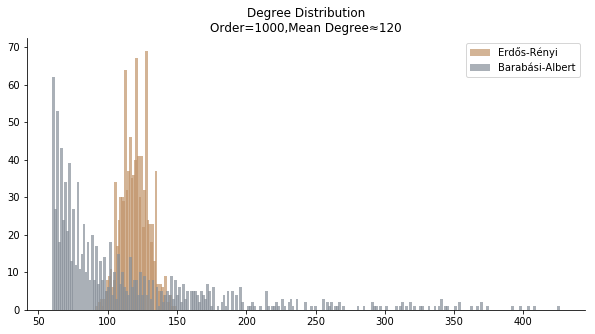

In [11]:
g1=nx.erdos_renyi_graph(n=N,p=120/N)
g2=nx.barabasi_albert_graph(n=N,m=60)

ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.hist(dict(g1.degree).values(),
         alpha=0.7,bins=50,width=2,
         label='Erdős-Rényi',color='#C1946A')
plt.hist(dict(g2.degree).values(),
         alpha=0.7,bins=250,width=2,
         label='Barabási-Albert',color='#878F99')
plt.title('Degree Distribution\nOrder=1000,Mean Degree≈120')
plt.legend(loc=0)
plt.show()

&nbsp;
### Mean Degree
&nbsp;

In [12]:
#get index of the number closest to int
@numba.jit(nopython=True)
def get_index(data):
    
    #convert to int
    integer=[int(x) for x in data]
    
    #get first order difference
    dif=np.subtract(np.array(integer[1:-1]),np.array(integer[:-2]))
    
    #find the number closest to int
    ind=[0]
    for i in range(len(dif)):
        if dif[i]!=0:
            ind.append(i+1)
    ind.append(len(integer)-1)
    
    return ind

#convert time and susceptible to int
@numba.jit(nopython=True)
def get_int(t_old,S_old,ind):
    
    t_new=[int(t_old[i])+1 for i in ind]
    S_new=[S_old[i] for i in ind]
    
    return t_new,S_new

In [13]:
#simulate two different graph model with different mean degree
def simulation(target_mean_degree,param,num=100,save_fig=False):
    
    #initial
    tmax,t,infection_rate,recovery_rate,S0,I0,R0=param
    N=S0+I0+R0
    
    #simulate each mean degree
    for target in target_mean_degree:
        
        #viz
        ax=plt.figure(figsize=(10,5)).add_subplot(111)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        #use dictionary for storage
        D1,D2={},{}
        for i in range(tmax+1):
            D1[i],D2[i]=[],[]
        
        #monte carlo
        for _ in range(num):
            
            #two different types
            g1=nx.erdos_renyi_graph(n=N,p=target/N)
            adjmatrix1=nx.to_numpy_array(g1)
            g2=nx.barabasi_albert_graph(n=N,m=int(target/2))
            adjmatrix2=nx.to_numpy_array(g2)
            
            #use gillespie algorithm to simulate epidemic size
            list_t1,_,list_S1,_,_=gillespie(adjmatrix1,param)
            list_t2,_,list_S2,_,_=gillespie(adjmatrix2,param)
            
            #convert to int time
            index1=get_index(list_t1)
            t_int1,S_int1=get_int(list_t1,list_S1,index1)
            index2=get_index(list_t2)
            t_int2,S_int2=get_int(list_t2,list_S2,index2)
            
            #plot simulation
            plt.plot(t_int1,S_int1,color='#a0a1a0',alpha=0.1)
            plt.plot(t_int2,S_int2,color='#a0a1a0',alpha=0.1)
            
            #keep all data for mean caculation
            for j in range(len(t_int1)):
                if t_int1[j]<=tmax:
                    D1[t_int1[j]].append(S_int1[j])            
            for k in range(len(t_int2)):
                if t_int2[k]<=tmax:
                    D2[t_int2[k]].append(S_int2[k])            
        
        #plot mean
        key1=[i for i in D1.keys() if D1[i]]
        plt.plot(key1,[np.mean(D1[ii]) for ii in key1],
                 color='#d6ce15',label='Erdős-Rényi',alpha=0.9)
        key2=[i for i in D2.keys() if D2[i]]
        plt.plot(key2,[np.mean(D2[ii]) for ii in key2],
                 color='#87c735',label='Barabási-Albert',alpha=0.9)
        
        #viz
        plt.legend(loc=1)
        plt.xlim(0,tmax)
        plt.ylim(0,N)
        plt.xlabel('Time')
        plt.ylabel('Population')
        plt.title(f'Susceptible\nMean Degree={target}')
        
        #save fig so we can make gif animation
        if save_fig:
            figname=f"{target}.png"
            plt.savefig(figname.lower())

        plt.show()

In [14]:
#maximum elapsed time
tmax=150

#beginning time
t=0

#initial
infection_rate=0.0001
recovery_rate=0.0003
S0=999
I0=1
R0=0

#data preparation
param=(tmax,t,infection_rate,recovery_rate,S0,I0,R0)
target_mean_degree=np.arange(25,300,25)

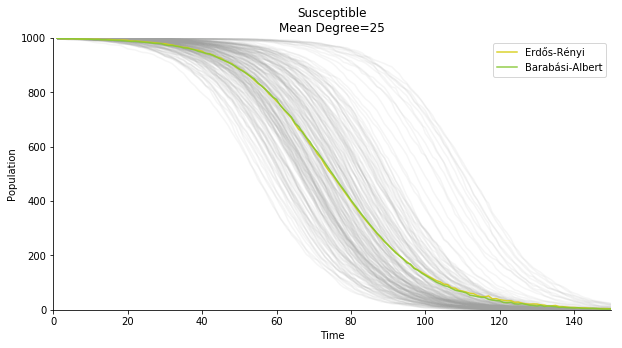

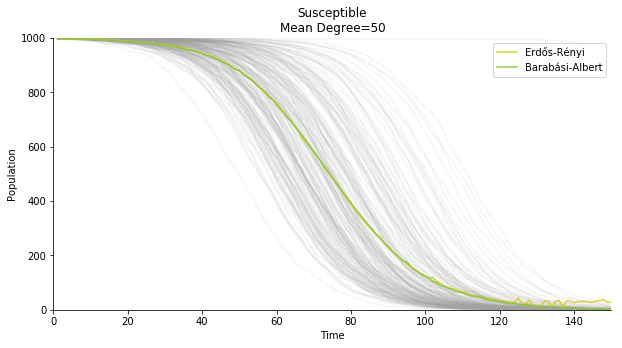

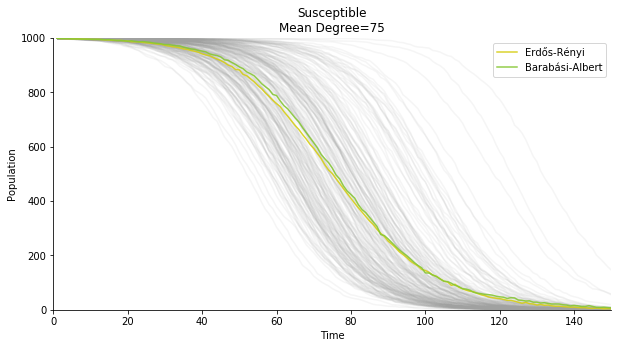

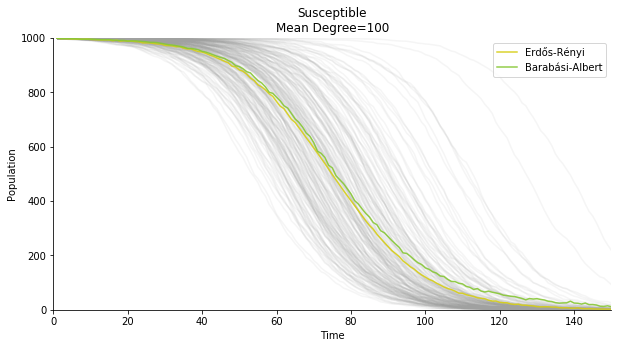

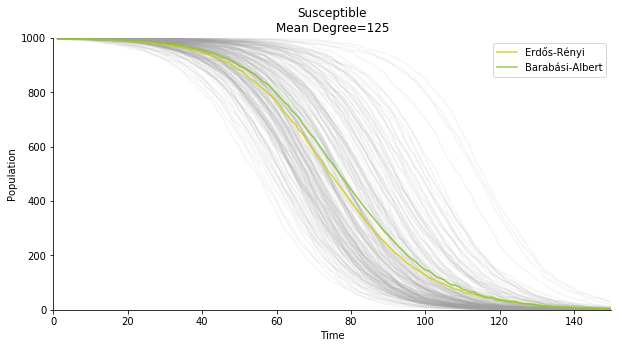

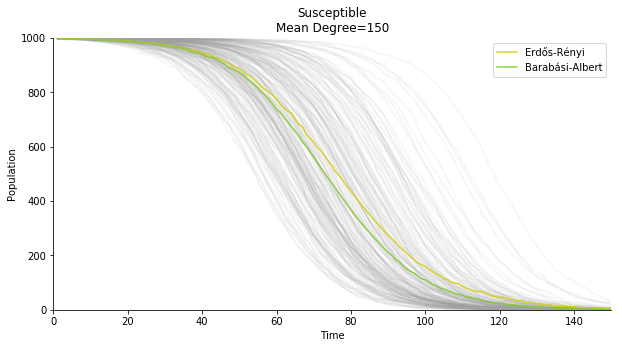

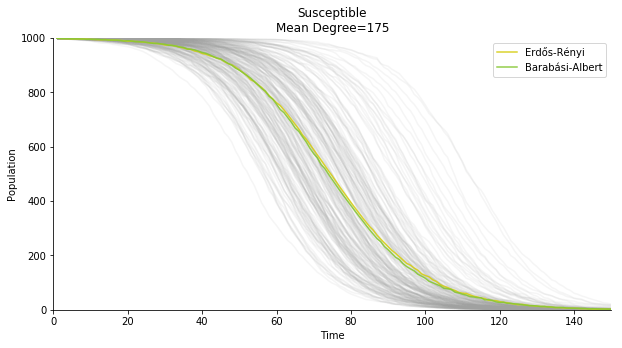

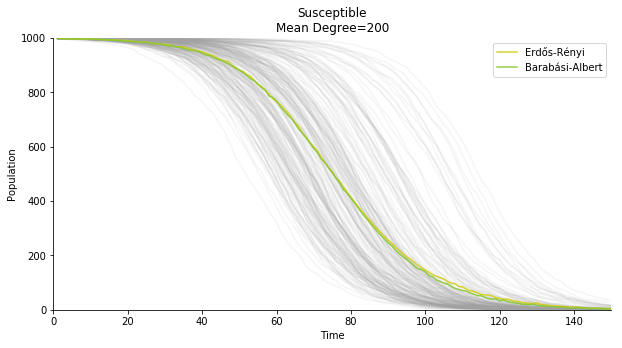

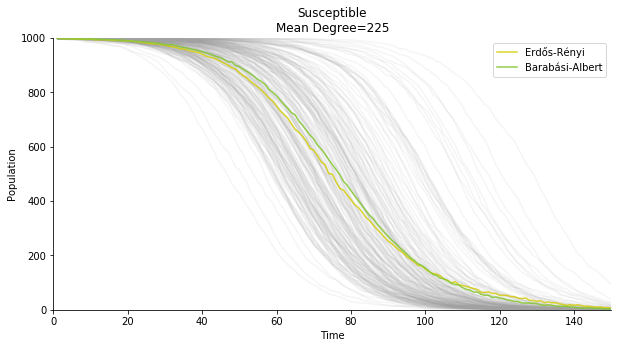

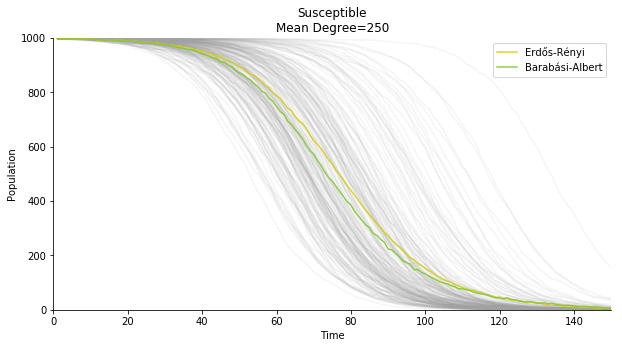

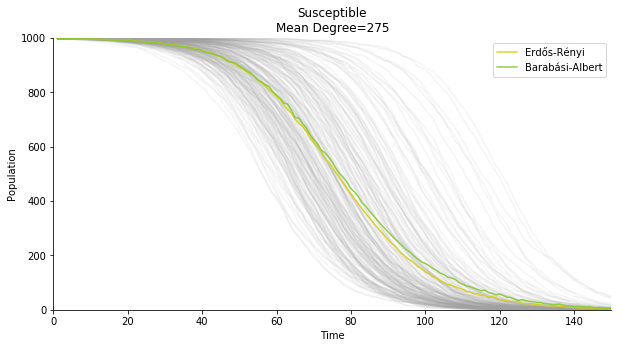

In [15]:
simulation(target_mean_degree,param,save_fig=True)

In [16]:
filenames=["%d.png" % (ii) for ii in target_mean_degree]
images=list(map(lambda filename:imageio.imread(filename),
                        filenames))
imageio.mimsave('movie.gif',images,duration=0.5)